In [45]:
from pathlib import Path
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.layers import BatchNormalization, Dense, Input, Conv1D, Add, ELU, Flatten, MaxPooling1D
from keras.layers import GlobalAveragePooling1D, Softmax, Concatenate, Reshape, Multiply, Dropout
from keras.optimizers import SGD
from keras import activations
from keras import Model
from keras.initializers import HeNormal
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from load_dataset import load_original_daic, load_labels
import matplotlib.pyplot as plt
import numpy as np
from keras.utils.vis_utils import plot_model

In [2]:
daic_lm_train = load_original_daic("original_daic/train", "features")
daic_lm_dev = load_original_daic("original_daic/dev", "features")
daic_lm_test = load_original_daic("original_daic/test", "features")

In [3]:
label_path = Path("original_daic/labels")
loaded_labels = load_labels(label_path)
y_train = np.array(loaded_labels["train"])
y_dev = np.array(loaded_labels["dev"])
y_test = np.array(loaded_labels["test"])

In [4]:
lm_train = []
lm_dev = []
lm_test = []
for subject_id, subject_df in daic_lm_train.items():
    temp = subject_df.copy().loc[1000:5999].to_numpy(dtype="float32")
    lm_train.append(temp)
for subject_id, subject_df in daic_lm_dev.items():
    # print(subject_id)
    temp = subject_df.copy().loc[1000:5999].to_numpy(dtype="float32")
    lm_dev.append(temp)
for subject_id, subject_df in daic_lm_test.items():
    # print(subject_id)
    temp = subject_df.copy().loc[1000:5999].to_numpy(dtype="float32")
    lm_test.append(temp)

In [5]:
all_samples = lm_train + lm_dev + lm_test
# all_samples = np.array(lm_train + lm_dev + lm_test, dtype=object)
all_samples = np.concatenate((all_samples),)
# all_samples.shape
min_values = all_samples.min(axis=0)
ptp_ranges = all_samples.ptp(axis=0)

In [6]:
lm_train = np.array(lm_train)
lm_dev = np.array(lm_dev)
lm_test = np.array(lm_test)

In [7]:
norm_lm_train = (lm_train - min_values)/ptp_ranges
norm_lm_dev = (lm_dev - min_values)/ptp_ranges
norm_lm_test = (lm_test - min_values)/ptp_ranges

In [8]:
# depressed_only = norm_lm_train[train_depressed_idx]
indices = range(norm_lm_train.shape[0])
oversample = RandomOverSampler(sampling_strategy='minority')
# oversample = RandomOverSampler(sampling_strategy=0.75)
# print(norm_lm_train[:].shape)
indices = np.array(indices).reshape(-1,1)
ros_indices, over_train_y = oversample.fit_resample(indices, y_train)
print(len(ros_indices))
ros_norm_lm_train = np.squeeze(norm_lm_train[ros_indices])
# print(ros_norm_lm_train.shape)

154


In [9]:
input_lm = Input(shape=[5000, 136])
tdcn_dim_lm = [256,256,128,64,64] # used in Guo's paper
# tdcn_dim_lm = [256,256,256,256,256]
bias_initializer = HeNormal(seed=0)

In [10]:
# One DCB
# first layer of the DCB
def diluted_conv_block(inputs, feature_dim):
    # with K.name_scope(block_name)
    l1_p1 = Conv1D(filters=feature_dim, kernel_size=3, padding="same", dilation_rate=1, use_bias=True, bias_initializer=bias_initializer)(inputs)
    l1_p2 = Conv1D(filters=feature_dim, kernel_size=3, padding="same", dilation_rate=1, use_bias=True, bias_initializer=bias_initializer)(inputs)
    l1_add = Add()([l1_p1, l1_p2])
    l1_ELU = ELU()(l1_add)
    # second layer of the DCB
    l2_p1 = Conv1D(filters=feature_dim, kernel_size=3, padding="same", dilation_rate=2, use_bias=True, bias_initializer=bias_initializer)(l1_ELU)
    l2_p2 = Conv1D(filters=feature_dim, kernel_size=3, padding="same", dilation_rate=2, use_bias=True, bias_initializer=bias_initializer)(l1_ELU)
    l2_add = Add()([l2_p1, l2_p2])
    l2_ELU = ELU()(l2_add)
    # third layer of the DCB
    l3_p1 = Conv1D(filters=feature_dim, kernel_size=3, padding="same", dilation_rate=4, use_bias=True, bias_initializer=bias_initializer)(l2_ELU)
    l3_p2 = Conv1D(filters=feature_dim, kernel_size=3, padding="same", dilation_rate=4, use_bias=True, bias_initializer=bias_initializer)(l2_ELU)
    l3_add = Add()([l3_p1, l3_p2])
    l3_ELU = ELU()(l3_add)

    residual = Conv1D(filters=feature_dim, kernel_size=1, padding="same")(inputs)
    res_add = Add()([l3_ELU, residual])
    # res_add = Add()([l1_ELU, residual])
    # res_add = ELU()(res_add)
    bn = BatchNormalization()(res_add)
    return bn
    # return residual

In [18]:
def time_diluted_conv_net(feature_dim, input_layer, pool_size, pool_stride):
    dcb_1 = diluted_conv_block(input_layer, feature_dim[0])
    mp_1 = MaxPooling1D(pool_size=pool_size, strides=pool_stride, padding='valid')(dcb_1)
    dcb_2 = diluted_conv_block(mp_1, feature_dim[1])
    mp_2 = MaxPooling1D(pool_size=pool_size, strides=pool_stride, padding='valid')(dcb_2)
    dcb_3 = diluted_conv_block(mp_2, feature_dim[2])
    mp_3 = MaxPooling1D(pool_size=pool_size, strides=pool_stride, padding='valid')(dcb_3)
    dcb_4 = diluted_conv_block(mp_3, feature_dim[3])
    mp_4 = MaxPooling1D(pool_size=pool_size, strides=pool_stride, padding='valid')(dcb_4)
    dcb_5 = diluted_conv_block(mp_4, feature_dim[4])
    return dcb_5
    # return dcb_2

# TDCN block for lm
tdcn_lm = time_diluted_conv_net(
    feature_dim = tdcn_dim_lm, 
    input_layer = input_lm, 
    pool_size = 2, 
    pool_stride = 2,
    )

# FWA block
concat_layer = Concatenate()([tdcn_lm])
# print(concat_layer.shape)
# gap_layer = GlobalAveragePooling1D(data_format="channels_last")(concat_layer)
gap_layer = GlobalAveragePooling1D(data_format="channels_last")(tdcn_lm)
# print(gap_layer.shape)

linear_layer_1 = Dense(gap_layer.shape[1])(gap_layer)
# relu_layer = Dense(128, activation = "relu")(linear_layer_1)
relu_layer = activations.relu(linear_layer_1)
# relu_layer = ReLU()(linear_layer_1)
linear_layer_2 = Dense(gap_layer.shape[1])(relu_layer)
# sigmoid_layer = Dense(128, activation = "sigmoid")(linear_layer_2)
sigmoid_layer = activations.sigmoid(linear_layer_2)
# reshape_layer = Reshape((312, 128),)(sigmoid_layer)
# print(reshape_layer.output_shape)
# elementwise_product = Multiply()([concat_layer, reshape_layer])
# elementwise_product = Multiply()([concat_layer, sigmoid_layer])
elementwise_product = Multiply()([tdcn_lm, sigmoid_layer])
print(elementwise_product.shape)
# FC layer
flatten = Flatten()(elementwise_product)
print(flatten.shape)
FC_l1 = Dense(16, activation="relu")(flatten)
FC_l2 = Dense(12, activation="relu")(FC_l1)
FC_l3 = Dense(8, activation="relu")(FC_l2)
last_layer = Dense(2, activation="relu")(FC_l3)

# FC_l1 = Dense(16, activation="relu")(flatten)
# dropout1 = Dropout(0.5)(FC_l1)
# FC_l2 = Dense(12, activation="relu")(dropout1)
# dropout2 = Dropout(0.5)(FC_l2)
# FC_l3 = Dense(8, activation="relu")(dropout2)
# dropout3 = Dropout(0.5)(FC_l3)
# last_layer = Dense(2, activation="relu")(dropout3)

output = Softmax()(last_layer)
# output = Dense(1, activation = "sigmoid")(FC_l3)

(None, 312, 64)
(None, 19968)


In [ ]:
model_lm = Model(inputs=[input_lm], outputs=[output])

In [80]:
model_lm = load_model("saved_models/lm_13_7_A2")

In [ ]:
checkpoint_path = Path("training_ckpts/lm_training_A")

cp_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)


In [84]:
opt = SGD(learning_rate = 2e-6, momentum = 0.9)
# opt = SGD(learning_rate = 2e-5, momentum = 0.9, nesterov=True)
# model_lm.compile(loss = "binary_crossentropy", optimizer=opt, metrics=['accuracy'])
model_lm.compile(loss = "sparse_categorical_crossentropy", optimizer = opt, metrics = ["accuracy"])

In [85]:
# model_lm.fit(lm_train[:], y_train[:], validation_data=(lm_dev[:], y_dev[:]), epochs=5)
model_lm.fit(ros_norm_lm_train[:], over_train_y, validation_data=(norm_lm_dev[:], y_dev[:]), epochs=6, batch_size=8)

Epoch 1/6
 8/20 [===========>..................] - ETA: 32s - loss: 0.5119 - accuracy: 0.6875

KeyboardInterrupt: 

2/2 [==============================] - 3s 292ms/step
[1 0 0 1 0 1 0 1 1 1 1 0 0 1 1 1 1 0 0 1 0 1 1 1 1 1 0 0 0 1 0 0 0 0 0]
[[0.70588235 0.61111111]
 [0.29411765 0.38888889]]


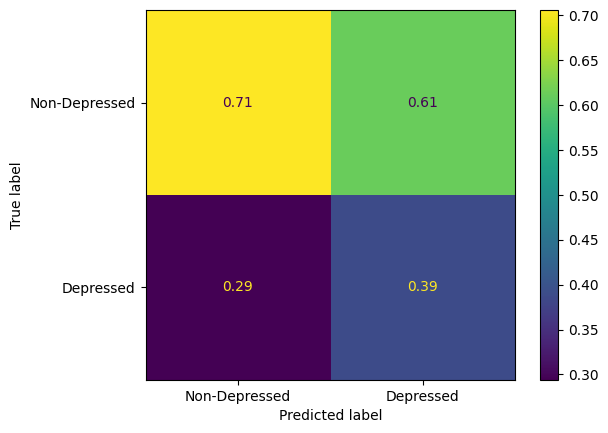

Accuracy = 0.5473856209150327
Recall = 0.569377990430622
Precision = 0.3888888888888889
F1-score = 0.4621359223300971


In [83]:
#Predict
x = norm_lm_dev
y = y_dev
# x = x_dev_bad
# y = y_dev_bad
y_lm_prediction = model_lm.predict(x)
y_lm_prediction = np.argmax(y_lm_prediction, axis = 1)
# print(sum(y_lm_prediction)/len(y_lm_prediction))
print(y_lm_prediction)
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y, y_lm_prediction, normalize='pred')
print(result)
cm_display = ConfusionMatrixDisplay(confusion_matrix = result, display_labels = ["Non-Depressed", "Depressed"])
cm_display.plot()
plt.show()
tn_lm = result[0][0]
tp_lm = result[1][1]
fn_lm = result[1][0]
fp_lm = result[0][1]
accuracy = (tp_lm + tn_lm)/(tp_lm + tn_lm + fp_lm + fn_lm)
recall = tp_lm / (tp_lm + fn_lm)
precision = tp_lm / (tp_lm + fp_lm)
f1_score = 2 * precision * recall / (precision + recall)
print("Accuracy = " + str(accuracy))
print("Recall = " + str(recall))
print("Precision = " + str(precision))
print("F1-score = " + str(f1_score))

In [ ]:
model_lm.summary()

In [54]:
# model_lm.save("saved_models/lm_13_7_A2")

INFO:tensorflow:Assets written to: saved_models/lm_13_7_A2\assets


INFO:tensorflow:Assets written to: saved_models/lm_13_7_A2\assets
